# A COMPARATIVE ANALYSIS OF SIMPLEX AND SINKHORN ALGORITHMS IN COMPUTATIONAL OPTIMAL TRANSPORT

## MATTEO CASIRAGHI

In [85]:
#LIBRARIES

import numpy as np

from scipy.optimize import linprog 

from scipy.optimize import curve_fit

from scipy.stats import linregress

import networkx as nx

import matplotlib.pyplot as plt

import time

import pandas as pd

from matplotlib.animation import FuncAnimation

from IPython.display import HTML

import seaborn as sns

from numpy import log

#### FUNCTIONS

In [2]:
def generate_random_locations(n, x_range=(0, 5), y_range=(0, 5)):
    """Function to generate random suppliers and demanders locations"""
    
    locations = np.zeros((n, 2))
    
    for i in range(n):
        locations[i] = np.random.uniform(x_range[0], x_range[1]), np.random.uniform(y_range[0], y_range[1])
        
    return locations

In [3]:
def extract_edges(P):
    """Function to extract paths from suppliers to consumers"""

    edges = []
    
    for i in range(P.shape[0]):
        for j in range(P.shape[1]):
            if P[i, j] > 0:
                edges.append((i, j))
                
    return edges

In [4]:
def generate_points(edges, locations):
    """Function to create a point for each demand satisfied by a precise supply"""
    
    points = []
    
    for edge in edges:
        points.append(locations[edge[0]])
        
    return np.array(points)

In [5]:
def generate_demand_points(locations, b):
    """Function to create demand points"""
    
    demand_points = []

    for i in range(len(b)):
        if b[i] > 0:
            demand_points.append(locations[i])

    return np.array(demand_points)

In [6]:
def plot_geographic_points(supply_points, demand_points):
    """Function to plot supply and demand points for each state on the geographic map"""
    
    plt.figure(figsize=(6, 4))
    
    plt.axis('off')
    
    plt.scatter(supply_points[:, 1], supply_points[:, 0], c='red', label='Supply', edgecolors='k', zorder=2)
    
    plt.scatter(demand_points[:, 1], demand_points[:, 0], c='blue', label='Demand', edgecolors='k', zorder=2)

In [7]:
def animate_supply_demand(points, demand, edges, steps=100):
    """Function to implement animation of transportation of goods from suppliers to consumers"""
    
    min_x = min(min(points[:, 1]), min(demand[:, 1]))
    max_x = max(max(points[:, 1]), max(demand[:, 1]))
    min_y = min(min(points[:, 0]), min(demand[:, 0]))
    max_y = max(max(points[:, 0]), max(demand[:, 0]))

    x_range = max_x - min_x
    y_range = max_y - min_y

    x_padding = x_range * 0.1
    y_padding = y_range * 0.1

    xlim = (min_x - x_padding, max_x + x_padding)
    ylim = (min_y - y_padding, max_y + y_padding)

    fig, ax = plt.subplots(figsize=(12, 6))

    ax.scatter(demand[:, 1], demand[:, 0], color='blue', label='Demand', edgecolors='k')

    animated_points_outline = [ax.plot(supply_point[1], supply_point[0], 'ko', markersize=6)[0] for supply_point in points]

    animated_points = [ax.plot(supply_point[1], supply_point[0], 'ro', markersize=4)[0] for supply_point in points]

    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim[0], ylim[1])

    def init():
        
        for point, outline in zip(animated_points, animated_points_outline):
            point.set_data([], [])
            outline.set_data([], [])

        return animated_points + animated_points_outline

    def update(frame):

        for i, (point, outline) in enumerate(zip(animated_points, animated_points_outline)):
            
            t = frame / steps  

            new_position = points[i] * (1 - t) + demand[edges[i][1]] * t

            point.set_data(new_position[1], new_position[0])
            outline.set_data(new_position[1], new_position[0])

            if frame == steps:
                point.set_color('lightgreen')

        return animated_points + animated_points_outline

    ani = FuncAnimation(fig, update, frames=np.linspace(0, steps, steps), init_func=init, blit=True, interval=50)

    plt.close(fig)  

    return HTML(ani.to_jshtml())

In [8]:
def generate_random_OT_problem(n, m, goods, cost_range=(0, 1)):
    """Function to generate random instances of OT problems"""

    supply_vector = np.random.multinomial(goods, np.random.dirichlet(np.ones(n) * 0.9))
    demand_vector = np.random.multinomial(goods, np.random.dirichlet(np.ones(m) * 0.9))
    
    demand_vector = demand_vector[demand_vector > 0]
    
    cost_matrix = np.random.uniform(cost_range[0], cost_range[1], size=(n, len(demand_vector)))
    
    return cost_matrix, supply_vector, demand_vector

In [9]:
def check_demands_satisfied(P, b):
    """function to check if solution is feasible"""
    
    return np.all(np.sum(P, axis=0) >= b)

In [10]:
def plot_heatmap(matrix):
    """Plot a heatmap of the given matrix"""

    plt.figure(figsize=(8, 6))
    
    plt.imshow(matrix, aspect='auto', cmap='Blues', interpolation='none', vmin=np.min(matrix), vmax=np.max(matrix))

    plt.colorbar()
    
    plt.title("Heatmap of the Matrix")
    plt.show()

#### OPTIMAL TRANSPORT (OT) PROBLEM

We initialize the mathematical elements that compose the problem.

In [11]:
C , a , b = generate_random_OT_problem(4, 4, 100)

In [12]:
C # Cost Matrix representing the price of transporting goods from each supplier to each consumer

array([[0.12451647, 0.9168277 , 0.15572411, 0.74020157],
       [0.14809856, 0.1972453 , 0.23146895, 0.13354837],
       [0.63977965, 0.74774921, 0.06094658, 0.91394563],
       [0.60655257, 0.8368935 , 0.00543668, 0.45868444]])

In [13]:
a # supply vector

array([12, 15, 66,  7])

In [14]:
b # demand vector

array([19,  3, 29, 49])

#### LINEAR FORMULATION

In this section we state the (OT) problem using the standard linear form, in order to solve it using the Simplex Algorithm.

In [15]:
def construct_lp_components(C, a, b):
    """Function to customize the problem for the linear resolution"""
       
    n, m = C.shape
    
    # we convert the cost matrix into a cost vector
    c = C.flatten() 

    # we create the constraint matrix
    A = np.zeros((n + m, n * m)) 
    
    for i in range(n):
        A[i, i*m:(i+1)*m] = 1
    
    for j in range(m):
        A[n + j, j::m] = 1
    
    # we create the constraint vector as the tower of the supply and demand vectors
    ab = np.concatenate([a, b])
    
    return c, A, ab

In [16]:
c, A, ab = construct_lp_components(C, a, b)

In [17]:
c # cost vector

array([0.12451647, 0.9168277 , 0.15572411, 0.74020157, 0.14809856,
       0.1972453 , 0.23146895, 0.13354837, 0.63977965, 0.74774921,
       0.06094658, 0.91394563, 0.60655257, 0.8368935 , 0.00543668,
       0.45868444])

In [18]:
A # constraint matrix

array([[1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
       [1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1.]])

In [19]:
ab # supply-demand vector

array([12, 15, 66,  7, 19,  3, 29, 49])

We are looking for $P$

The Transport Plan matrix that represents the solution to the (OT) problem. 

This solution has to respect two constraints:

$P1 = a$ and $P^T1 = b$ 

We define the elements of $U(a,b)$ as all the P matrices satisfying the previous two constraints.

Moreover, we move from this structure to the linear formulation:

$$
P \in \mathbb{R}^{n \times m} \in U(a,b) \iff p \in \mathbb{R}^{nm}, A p = ab
$$

#### SIMPLEX ALGORITHM

In this section we show the Simplex Method structure.

In [20]:
def simplex(C, a, b):
    """Function to solve the OT problem stated with linear formulation"""
    
    n, m = C.shape
    
    c, A_eq, b_eq = construct_lp_components(C, a, b)

    bounds = [(0, None) for _ in range(n * m)]
    
    result = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')
    
    if result.success:

        p = result.x
        objective = np.dot(c, p)
        P = p.reshape(n, m)

        return P, objective
    
    else:
        
        raise Exception("Linear programming did not converge: " + result.message)

In [21]:
P, minimal_cost = simplex(C, a, b)

In [22]:
P # Optimal Transport Plan

array([[12.,  0.,  0.,  0.],
       [ 0.,  0.,  0., 15.],
       [ 7.,  3., 29., 27.],
       [ 0.,  0.,  0.,  7.]])

In [23]:
minimal_cost # Minimal cost of transportation

39.8739025181916

#### VISUALIZATION

We visualize the results obtained through the Simplex Algorithm.                         

In [24]:
edges = extract_edges(P) 

In [25]:
edges # Extracting the paths from the optimal transport plan

[(0, 0), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3), (3, 3)]

In [26]:
supplier_locations = generate_random_locations(len(a))
demander_locations = generate_random_locations(len(b))

In [27]:
points = generate_points(edges, supplier_locations)

In [28]:
demand = generate_demand_points(demander_locations, b)

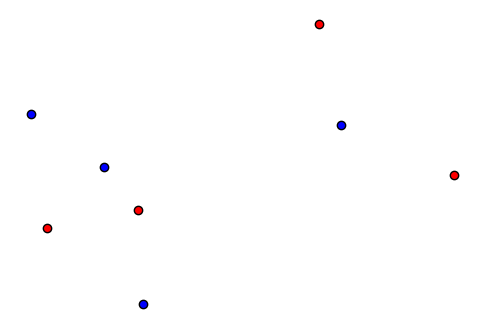

In [29]:
plot_geographic_points(supplier_locations, demander_locations)

#### ANIMATION

Thanks to the following animation we can detect which suppliers satisfy each demand.

In [30]:
animate_supply_demand(points, demand, edges, steps=50)

#### SIMPLEX NETWORK

In this section we explain how the Simplex Method works using the Graph $S(P)$ associated to the problem.

Since a graph with k nodes and no cycles cannot have more than k − 1 edges:

We conclude S(P) cannot have more than n + m − 1 edges, and P cannot have more than n + m − 1 nonzero entries.

In [31]:
non_zero_entries = np.count_nonzero(P)

n_plus_m_minus_1 = len(a) + len(b) - 1

if non_zero_entries <= n_plus_m_minus_1:
    print("The number of non-zero entries in P⋆ is less or equal to n+m-1.")
    
else:
    print("The number of non-zero entries in P⋆ is not less or equal to n+m-1.")

The number of non-zero entries in P⋆ is less or equal to n+m-1.


this condition is satisfied.

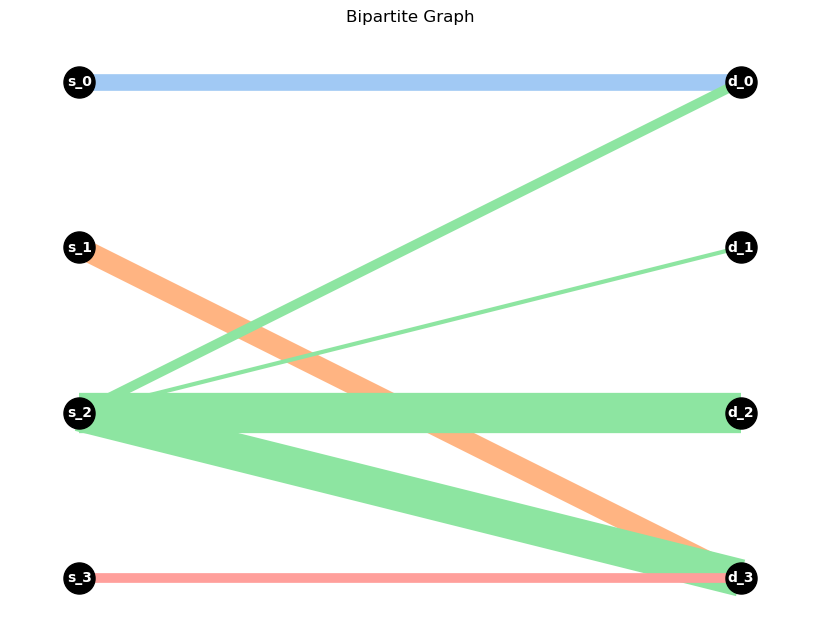

In [32]:
# SIMPLEX NETWORK

G = nx.Graph()

for i in range(len(a)):
    G.add_node(f's_{i}', pos=(0, i), color='red')

for j in range(len(b)):
    G.add_node(f'd_{j}', pos=(1, j), color='blue')

group_colors = {}

for i, j in edges:
    supply_node = f's_{i}'
    demand_node = f'd_{j}'
    
    if supply_node not in group_colors:

        group_colors[supply_node] = len(group_colors)
    
    edge_color = group_colors[supply_node]
    
    G.add_edge(supply_node, demand_node, weight=P[i, j], color=edge_color)

pos = nx.get_node_attributes(G, 'pos')
colors = nx.get_node_attributes(G, 'color')
weights = nx.get_edge_attributes(G, 'weight')
edge_colors = nx.get_edge_attributes(G, 'color')

edge_palette = plt.cm.get_cmap('Set3', len(group_colors))

edge_palette = sns.color_palette("pastel", len(group_colors))

pos = {node: (pos[node][0], len(b) - pos[node][1]) for node in pos}

plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=True, node_size=500, node_color='black', font_color='white', font_size=10, font_weight='bold')
nx.draw_networkx_edges(G, pos, width=list(weights.values()), edge_color=[edge_palette[c] for c in edge_colors.values()])
plt.title('Bipartite Graph')
plt.axis('off')
plt.show()

This graph shows the mass splitting phenomena among the consumers.

Moreover, the following graph represent one step in the simplex method:

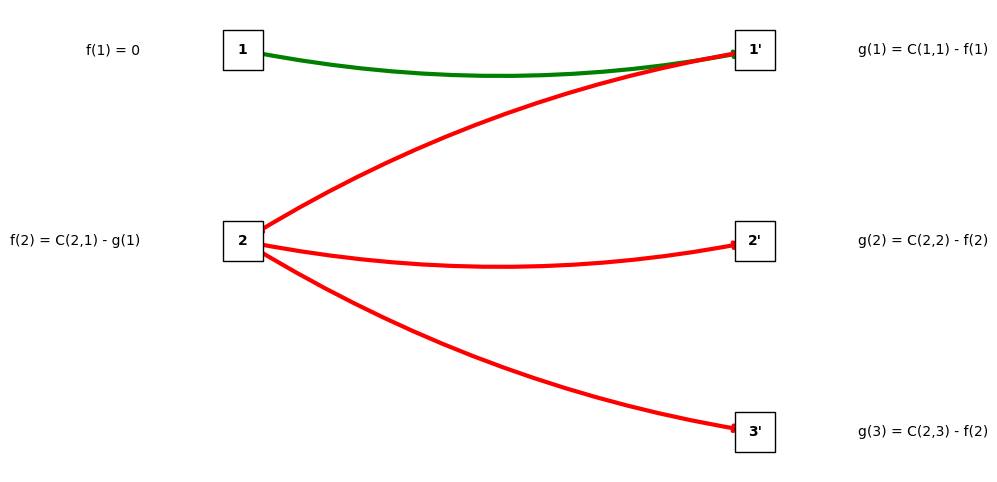

In [33]:
# EXAMPLE of Assignment for Netowrk Simplex

G = nx.DiGraph()

node_labels = {

    '1': 'f(1) = 0',
    "1'": 'g(1) = C(1,1) - f(1)',
    '2': 'f(2) = C(2,1) - g(1)',
    "2'": 'g(2) = C(2,2) - f(2)',
    "3'": 'g(3) = C(2,3) - f(2)'
}

vertical_spacing = 0.5

for node, label in node_labels.items():

    x = 0.5 if '\'' in node else 0 

    y = vertical_spacing * (2 - int(node[0]) if node[0].isdigit() else 2 - int(node[0][0]))  

    G.add_node(node, pos=(x, y), internal_label=node, external_label=label)

edges_with_colors = [
    
    ('1', "1'", 'green'),
    ("1'", '2', 'red'),
    ('2', "2'", 'red'),
    ('2', "3'", 'red')
]

for u, v, color in edges_with_colors:
    G.add_edge(u, v, color=color)

pos = nx.get_node_attributes(G, 'pos')

plt.figure(figsize=(8, 6))

nx.draw_networkx_nodes(G, pos, node_size=800, node_color='white', edgecolors='black', node_shape='s')

internal_labels = {node: data['internal_label'] for node, data in G.nodes(data=True)}
nx.draw_networkx_labels(G, pos, labels=internal_labels, font_size=10, font_weight='bold')

for node, data in G.nodes(data=True):
    
    node_pos = pos[node]
    label = data['external_label']

    if "'" in node:  
        label_pos = (node_pos[0] + 0.1, node_pos[1])
        ha = 'left'
    else:  
        label_pos = (node_pos[0] - 0.1, node_pos[1])
        ha = 'right'

    plt.text(label_pos[0], label_pos[1], label, fontsize=10, verticalalignment='center', horizontalalignment=ha)

edges = G.edges()
colors = [G[u][v]['color'] for u, v in edges]
nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=colors, width=3, connectionstyle='arc3,rad=0.1')

plt.axis('off')

plt.margins(0.05)

plt.show()


#### GLOBAL MARKET

In this section we present a possible application of Simplex Algorithm to solve an instance of (OT) problem, considering the global market of a precise good.

In [34]:
dataset_path = '/Users/matteocasiraghi/Desktop/THESIS/world_country_latitude_and_longitude_values.csv'

df = pd.read_csv(dataset_path, sep=';')

In [35]:
df #database with country locations

country_code   latitude  longitude               country
0             AD  42.546245   1.601554               Andorra
1             AE  23.424076  53.847818  United Arab Emirates
2             AF  33.939110  67.709953           Afghanistan
3             AG  17.060816 -61.796428   Antigua and Barbuda
4             AI  18.220554 -63.068615              Anguilla
..           ...        ...        ...                   ...
240           YE  15.552727  48.516388                 Yemen
241           YT -12.827500  45.166244               Mayotte
242           ZA -30.559482  22.937506          South Africa
243           ZM -13.133897  27.849332                Zambia
244           ZW -19.015438  29.154857              Zimbabwe

[245 rows x 4 columns]

In [36]:
df = df.dropna(subset=['latitude'])

In [37]:
locations = df[['latitude', 'longitude']].values # Extract the latitude and longitude into an array

In [38]:
locations

array([[ 4.25462450e+01,  1.60155400e+00],
       [ 2.34240760e+01,  5.38478180e+01],
       [ 3.39391100e+01,  6.77099530e+01],
       [ 1.70608160e+01, -6.17964280e+01],
       [ 1.82205540e+01, -6.30686150e+01],
       [ 4.11533320e+01,  2.01683310e+01],
       [ 4.00690990e+01,  4.50381890e+01],
       [ 1.22260790e+01, -6.90600870e+01],
       [-1.12026920e+01,  1.78738870e+01],
       [-7.52509730e+01, -7.13890000e-02],
       [-3.84160970e+01, -6.36166720e+01],
       [-1.42709720e+01, -1.70132217e+02],
       [ 4.75162310e+01,  1.45500720e+01],
       [-2.52743980e+01,  1.33775136e+02],
       [ 1.25211100e+01, -6.99683380e+01],
       [ 4.01431050e+01,  4.75769270e+01],
       [ 4.39158860e+01,  1.76790760e+01],
       [ 1.31938870e+01, -5.95431980e+01],
       [ 2.36849940e+01,  9.03563310e+01],
       [ 5.05038870e+01,  4.46993600e+00],
       [ 1.22383330e+01, -1.56159300e+00],
       [ 4.27338830e+01,  2.54858300e+01],
       [ 2.59304140e+01,  5.06377720e+01],
       [-3.

In [39]:
df = df.drop('country_code', axis=1)

In [40]:
df['market'] = np.random.choice([0, 1], size=len(df)) # Add 'market' column with random 1 = (supply) and 0 = (demand)

In [41]:
df

latitude  longitude               country  market
0    42.546245   1.601554               Andorra       0
1    23.424076  53.847818  United Arab Emirates       1
2    33.939110  67.709953           Afghanistan       0
3    17.060816 -61.796428   Antigua and Barbuda       0
4    18.220554 -63.068615              Anguilla       0
..         ...        ...                   ...     ...
240  15.552727  48.516388                 Yemen       0
241 -12.827500  45.166244               Mayotte       0
242 -30.559482  22.937506          South Africa       0
243 -13.133897  27.849332                Zambia       0
244 -19.015438  29.154857              Zimbabwe       0

[244 rows x 4 columns]

In [42]:
def generate_supply_demand_quantities(df, goods):
    """Function to generate the goods for an hypothetical global market"""
   
    num_suppliers = df[df['market'] == 1].shape[0]
    num_consumers = df[df['market'] == 0].shape[0]

    supply_quantities = np.random.multinomial(goods, np.random.dirichlet(np.ones(num_suppliers) * 0.9))
    demand_quantities = np.random.multinomial(goods, np.random.dirichlet(np.ones(num_consumers) * 0.9))

    df['goods'] = 0
    
    df.loc[df['market'] == 1, 'goods'] = supply_quantities  
    df.loc[df['market'] == 0, 'goods'] = demand_quantities  

    return df

In [43]:
df = generate_supply_demand_quantities(df, 1000)

In [44]:
df

latitude  longitude               country  market  goods
0    42.546245   1.601554               Andorra       0      5
1    23.424076  53.847818  United Arab Emirates       1      0
2    33.939110  67.709953           Afghanistan       0     10
3    17.060816 -61.796428   Antigua and Barbuda       0     21
4    18.220554 -63.068615              Anguilla       0     15
..         ...        ...                   ...     ...    ...
240  15.552727  48.516388                 Yemen       0      1
241 -12.827500  45.166244               Mayotte       0      2
242 -30.559482  22.937506          South Africa       0     10
243 -13.133897  27.849332                Zambia       0     18
244 -19.015438  29.154857              Zimbabwe       0     21

[244 rows x 5 columns]

We extract just those countries that partecipate in the market:

In [45]:
# filter only entries with demand in the market column

demanders = df[df['market'] == 0].reset_index(drop=True)
demanders = demanders.drop('market', axis=1)

In [46]:
zero_demanders = demanders[demanders['goods'] == 0]
demanders = demanders.drop(zero_demanders.index).reset_index(drop=True)

In [47]:
demanders

latitude  longitude              country  goods
0    42.546245   1.601554              Andorra      5
1    33.939110  67.709953          Afghanistan     10
2    17.060816 -61.796428  Antigua and Barbuda     21
3    18.220554 -63.068615             Anguilla     15
4    40.069099  45.038189              Armenia     10
..         ...        ...                  ...    ...
103  15.552727  48.516388                Yemen      1
104 -12.827500  45.166244              Mayotte      2
105 -30.559482  22.937506         South Africa     10
106 -13.133897  27.849332               Zambia     18
107 -19.015438  29.154857             Zimbabwe     21

[108 rows x 4 columns]

In [48]:
demander_locations_g = demanders[['latitude', 'longitude']].values

In [49]:
print(demander_locations_g)

[[ 4.25462450e+01  1.60155400e+00]
 [ 3.39391100e+01  6.77099530e+01]
 [ 1.70608160e+01 -6.17964280e+01]
 [ 1.82205540e+01 -6.30686150e+01]
 [ 4.00690990e+01  4.50381890e+01]
 [-7.52509730e+01 -7.13890000e-02]
 [-3.84160970e+01 -6.36166720e+01]
 [ 4.75162310e+01  1.45500720e+01]
 [-2.52743980e+01  1.33775136e+02]
 [ 1.25211100e+01 -6.99683380e+01]
 [ 4.01431050e+01  4.75769270e+01]
 [ 1.31938870e+01 -5.95431980e+01]
 [ 2.36849940e+01  9.03563310e+01]
 [ 5.05038870e+01  4.46993600e+00]
 [ 1.22383330e+01 -1.56159300e+00]
 [ 3.23213840e+01 -6.47573700e+01]
 [ 2.75141620e+01  9.04336010e+01]
 [-5.44231990e+01  3.41319400e+00]
 [-2.23284740e+01  2.46848660e+01]
 [ 5.37098070e+01  2.79533890e+01]
 [ 1.71898770e+01 -8.84976500e+01]
 [-1.21641650e+01  9.68709560e+01]
 [-4.03833300e+00  2.17586640e+01]
 [ 4.57086800e+00 -7.42973330e+01]
 [ 2.15217570e+01 -7.77811670e+01]
 [ 1.60020820e+01 -2.40131970e+01]
 [ 4.98174920e+01  1.54729620e+01]
 [ 5.11656910e+01  1.04515260e+01]
 [ 1.18251380e+01  4

In [50]:
# filter only entries with supply in the market column

suppliers = df[df['market'] == 1].reset_index(drop=True)
suppliers = suppliers.drop('market', axis=1)

In [51]:
zero_suppliers = suppliers[suppliers['goods'] == 0]
suppliers = suppliers.drop(zero_suppliers.index).reset_index(drop=True)

In [52]:
suppliers

latitude   longitude                 country  goods
0    41.153332   20.168331                 Albania      5
1   -11.202692   17.873887                  Angola      3
2    43.915886   17.679076  Bosnia and Herzegovina     10
3    42.733883   25.485830                Bulgaria      1
4    25.930414   50.637772                 Bahrain     12
..         ...         ...                     ...    ...
96   18.420695  -64.639968  British Virgin Islands      8
97   18.335765  -64.896335     U.S. Virgin Islands     25
98   14.058324  108.277199                 Vietnam     10
99  -15.376706  166.959158                 Vanuatu      3
100  42.602636   20.902977                  Kosovo      4

[101 rows x 4 columns]

In [53]:
supplier_locations_g = suppliers[['latitude', 'longitude']].values

In [54]:
print(supplier_locations_g)

[[ 4.11533320e+01  2.01683310e+01]
 [-1.12026920e+01  1.78738870e+01]
 [ 4.39158860e+01  1.76790760e+01]
 [ 4.27338830e+01  2.54858300e+01]
 [ 2.59304140e+01  5.06377720e+01]
 [-3.37305600e+00  2.99188860e+01]
 [ 4.53527700e+00  1.14727669e+02]
 [-1.62901540e+01 -6.35886530e+01]
 [-1.42350040e+01 -5.19252800e+01]
 [ 5.61303660e+01 -1.06346771e+02]
 [ 6.61111100e+00  2.09394440e+01]
 [-2.28021000e-01  1.58276590e+01]
 [-2.12367360e+01 -1.59777671e+02]
 [-3.56751470e+01 -7.15429690e+01]
 [ 7.36972200e+00  1.23547220e+01]
 [ 9.74891700e+00 -8.37534280e+01]
 [ 5.62639200e+01  9.50178500e+00]
 [ 1.54149990e+01 -6.13709760e+01]
 [ 1.87356930e+01 -7.01626510e+01]
 [-1.83123900e+00 -7.81834060e+01]
 [ 1.51793840e+01  3.97823340e+01]
 [ 4.04636670e+01 -3.74922000e+00]
 [ 6.19241100e+01  2.57481510e+01]
 [-1.65781930e+01  1.79414413e+02]
 [ 7.42555400e+00  1.50550812e+02]
 [ 6.18926350e+01 -6.91180600e+00]
 [ 4.62276380e+01  2.21374900e+00]
 [-8.03689000e-01  1.16094440e+01]
 [ 5.53780510e+01 -3

We show the variables describing the Global Market:

In [55]:
a_g = np.array(suppliers['goods']) 

In [56]:
a_g # supply vector

array([ 5,  3, 10,  1, 12,  4, 29, 12, 15, 10,  1,  2,  4,  3,  2,  6,  2,
        1, 10,  2,  5, 17, 19,  1, 15, 16, 17,  7,  1,  1,  9,  4, 21, 40,
        1, 22, 12,  2, 23,  5, 50,  2, 12,  8, 22,  3, 19, 16, 11,  1, 17,
       10, 10,  2,  6,  4, 14,  1, 11,  8,  1,  3, 10, 18, 16,  5,  2,  7,
        1, 21,  9, 18, 10,  6, 17, 30,  1, 12,  8,  8,  3,  3,  8, 10,  9,
        8,  4, 35, 11,  1,  1, 10, 10, 14, 14,  7,  8, 25, 10,  3,  4])

In [57]:
b_g = np.array(demanders['goods'])

In [58]:
b_g # demand vector

array([ 5, 10, 21, 15, 10, 13,  4,  6, 25,  1,  4,  1,  3,  2, 12,  1, 18,
        1,  5, 13,  1, 13,  8,  1, 26,  2,  7,  5,  3,  3, 38, 10,  3,  5,
        7, 10, 32,  6, 14,  9, 24,  2,  8,  2,  9,  9,  1,  2,  8, 17, 43,
        2,  9,  4,  8,  2, 25,  1,  5,  5,  8,  5, 10,  2, 11, 23,  1, 14,
       21,  3,  8,  2,  7,  6, 13, 11,  5,  2,  7,  1,  2, 31, 12,  3, 16,
        4,  4,  9,  8, 28,  1, 14,  6,  4,  4,  3,  1,  7,  1, 18,  6, 21,
       26,  1,  2, 10, 18, 21])

In [59]:
C_g = np.random.randint(1, 100, size=(len(a_g), len(b_g)))    

In [60]:
C_g # Cost Matrix

array([[81, 73, 96, ..., 11, 47, 36],
       [27, 88, 19, ..., 26, 92,  1],
       [87, 40, 16, ..., 53, 11, 26],
       ...,
       [24, 64, 42, ..., 44, 85, 76],
       [ 7, 19, 73, ..., 72, 71, 46],
       [78, 97, 42, ..., 45, 43, 99]])

In [61]:
P_g, sol_g = simplex(C_g, a_g, b_g)

In [62]:
P_g # Optimal Transport Plan

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [63]:
sol_g # Minimal cost of transportation

3508.0

In [64]:
demands_satisfied = check_demands_satisfied(P_g, b_g)
print("Are all demands satisfied?", demands_satisfied)

Are all demands satisfied? True


In [65]:
edges_g = extract_edges(P_g)

In [66]:
edges_g

[(0, 30),
 (1, 30),
 (2, 54),
 (2, 60),
 (3, 37),
 (4, 9),
 (4, 36),
 (5, 48),
 (6, 2),
 (6, 13),
 (6, 68),
 (6, 74),
 (6, 77),
 (6, 80),
 (6, 81),
 (6, 101),
 (7, 32),
 (7, 106),
 (8, 34),
 (8, 62),
 (8, 67),
 (9, 64),
 (9, 91),
 (10, 70),
 (11, 3),
 (12, 37),
 (12, 70),
 (13, 53),
 (14, 34),
 (15, 1),
 (16, 76),
 (17, 24),
 (18, 3),
 (18, 30),
 (18, 83),
 (19, 30),
 (20, 61),
 (21, 44),
 (21, 89),
 (22, 41),
 (22, 89),
 (23, 30),
 (24, 36),
 (25, 68),
 (25, 69),
 (25, 79),
 (26, 4),
 (26, 56),
 (26, 78),
 (27, 59),
 (27, 64),
 (28, 84),
 (29, 99),
 (30, 84),
 (31, 1),
 (32, 24),
 (32, 107),
 (33, 8),
 (33, 11),
 (33, 40),
 (33, 58),
 (33, 84),
 (33, 88),
 (34, 3),
 (35, 40),
 (35, 56),
 (35, 67),
 (36, 21),
 (36, 40),
 (37, 53),
 (37, 65),
 (38, 78),
 (38, 99),
 (38, 106),
 (39, 88),
 (40, 27),
 (40, 35),
 (40, 45),
 (40, 49),
 (40, 65),
 (41, 4),
 (42, 18),
 (42, 68),
 (43, 2),
 (43, 100),
 (44, 21),
 (44, 39),
 (44, 42),
 (44, 98),
 (45, 3),
 (46, 31),
 (46, 38),
 (46, 51),
 (46, 8

In [67]:
points_g = generate_points(edges_g, supplier_locations_g)

In [68]:
demand_g = generate_demand_points(demander_locations_g, b_g)

In [69]:
animate_supply_demand(points_g, demand_g, edges_g, steps=100)

#### TIME COMPLEXITY

In this section we analyze the time complexity of the Simplex algorithm in function of the number of suppliers/consumers.

In [81]:
def run_optimal_transport(n):
    """Function to run the optimal transport problem with a given number of locations"""

    C, a, b = generate_random_OT_problem(n, n, n * 50)

    start_time = time.time()

    transport_matrix , objective = simplex(C, a, b)

    end_time = time.time()

    elapsed_time = end_time - start_time

    print("Optimal Transport Matrix:\n\n", transport_matrix)
    print("\nobjective:\n\n", objective)
    print(f"\ntime with {n}:\n\n", elapsed_time)

    return transport_matrix, objective, elapsed_time 

In [87]:
results_array = run_optimal_transport(50)

Optimal Transport Matrix:

 [[ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... 44.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]

objective:

 187.1257728174063

time with 50:

 0.029017210006713867


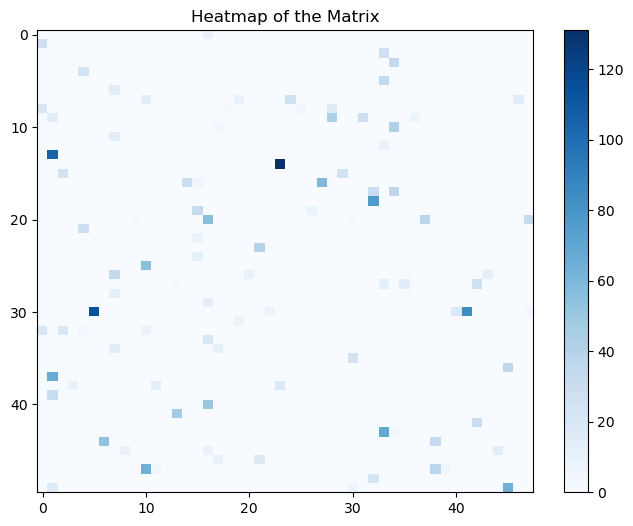

In [97]:
plot_heatmap(results_array[0])

In [88]:
results_array = run_optimal_transport(100)

Optimal Transport Matrix:

 [[  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0. 114.]
 [  0.   0.   0. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]]

objective:

 178.08582403004297

time with 100:

 0.19225192070007324


In [89]:
results_array = run_optimal_transport(150)

Optimal Transport Matrix:

 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

objective:

 193.491083634035

time with 150:

 0.7630059719085693


In [90]:
results_array = run_optimal_transport(200)

Optimal Transport Matrix:

 [[ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 ...
 [19.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]

objective:

 161.84578856396945

time with 200:

 2.7621219158172607


In [91]:
results_array = run_optimal_transport(250)

Optimal Transport Matrix:

 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

objective:

 160.4741150558846

time with 250:

 4.152546167373657


In [202]:
results_array = run_optimal_transport(300)

Optimal Transport Matrix:

 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

objective:

 142.75793938790233

time with 300:

 10.604420900344849


In [201]:
results_array = run_optimal_transport(350)

Optimal Transport Matrix:

 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

objective:

 176.5744216813793

time with 350:

 18.078120946884155


In [200]:
results_array = run_optimal_transport(400)

Optimal Transport Matrix:

 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

objective:

 170.60298005577746

time with 400:

 29.783164978027344


In [199]:
results_array = run_optimal_transport(450)

Optimal Transport Matrix:

 [[ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0. 36.  0.]]

objective:

 151.95175290410955

time with 450:

 51.71004128456116


In [203]:
results_array = run_optimal_transport(500)

Optimal Transport Matrix:

 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

objective:

 182.14500054107287

time with 500:

 118.56494784355164


In [195]:
results_array = run_optimal_transport(550)

Optimal Transport Matrix:

 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

objective:

 172.295422682937

time with 550:

 158.401850938797


In [212]:
results_array = run_optimal_transport(600)

Optimal Transport Matrix:

 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

objective:

 168.0026570630806

time with 600:

 202.5902440547943


In [211]:
results_array = run_optimal_transport(650)

Optimal Transport Matrix:

 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

objective:

 164.81710260178744

time with 650:

 299.17874789237976


In [100]:
results_array = run_optimal_transport(700)

Optimal Transport Matrix:

 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

objective:

 182.2755250967109

time with 700:

 396.1100649833679


In [213]:
# example of collected results through simulations

results_array_tot = [
[  50, 0.029017210006713867],
[  100, 0.19225192070007324],
[  150, 0.7630059719085693],
[  200, 2.7621219158172607],
[  250, 4.152546167373657],
[  300, 10.604420900344849],
[  350, 18.078120946884155],
[  400, 29.783164978027344],
[  450, 51.71004128456116],
[  500, 118.56494784355164],
[  550, 158.401850938797],
[  600, 202.5902440547943],
[  650, 299.17874789237976],
[  700, 396.1100649833679]]

In [214]:
tuples_array = np.array([(x[0], x[1]) for x in results_array_tot])

n_values = tuples_array[:, 0]  
time_values = tuples_array[:, 1]  

We visualize the empirical data collected running the above implemented Simplex Algorithm.

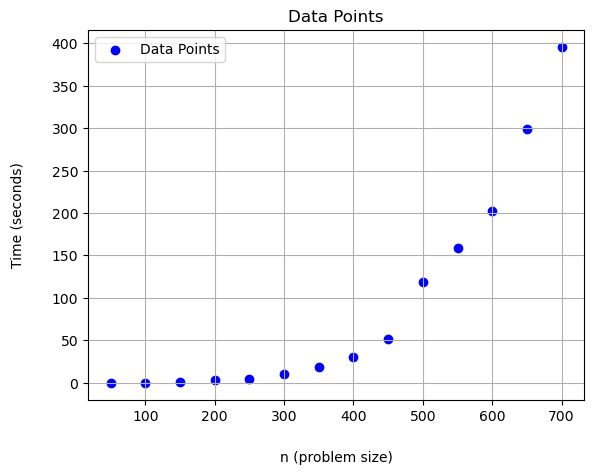

In [215]:
plt.scatter(n_values, time_values, color='blue', label='Data Points')

plt.xlabel('n (problem size)', labelpad=20)
plt.ylabel('Time (seconds)', labelpad=20)

plt.title('Data Points')

plt.legend()
plt.grid(True)
plt.show()

From the literature the time complexity of the algorithm should be:
$$
O\left( (n+m)nm \log(n+m) \log((n+m) \lVert C \rVert_{\infty}) \right)
$$

For this function we can only compute an average value between those assumed during the iterations. This approximation is probably one of the main point related to the noise in the time complexity curve fitted through empriical data.

In [216]:
def f_simplex(n):
    return n**3 * np.log(2*n) * np.log(2 * n)

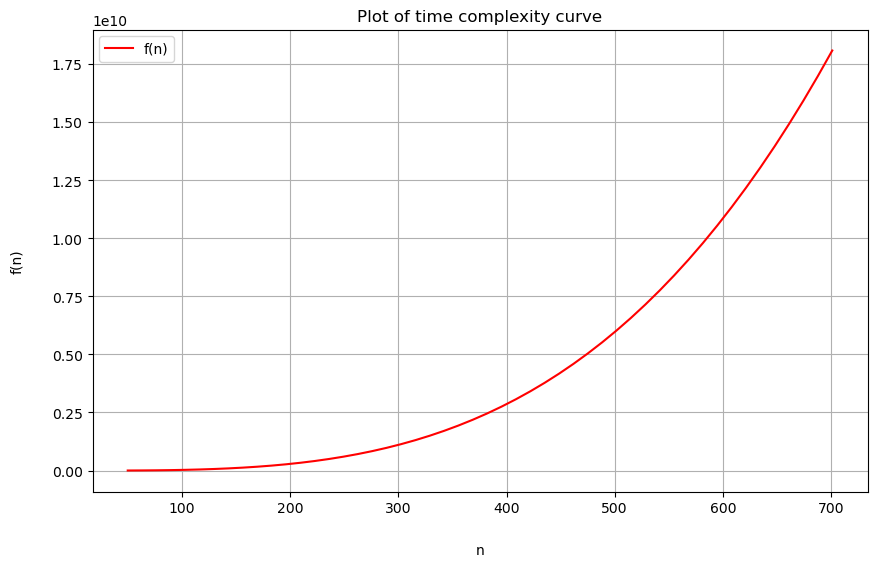

In [217]:
values = np.linspace(50, 701, 50)

f_values = f_simplex(values)

plt.figure(figsize=(10, 6))

plt.plot(values, f_values, label='f(n)', color='red')

plt.xlabel('n', labelpad=20)
plt.ylabel('f(n)', labelpad=20)

plt.title('Plot of time complexity curve')

plt.legend()
plt.grid(True)
plt.show()

In [218]:
def model(n, F):
    """Function to fit the time complexity curve"""
    
    return F * f_simplex(n)

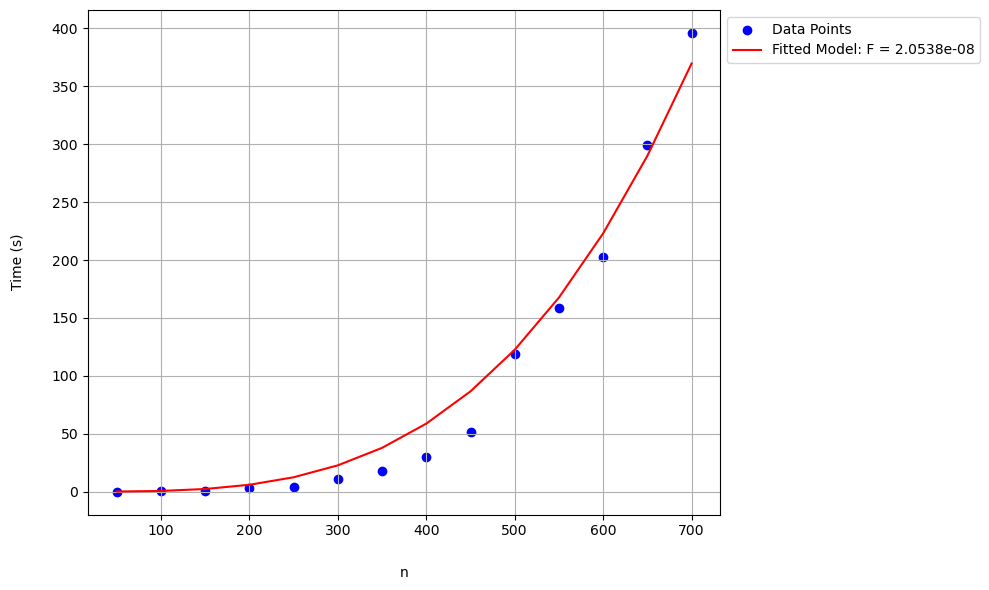

In [219]:
params, covariance = curve_fit(model, n_values, time_values, p0=0.0001)

fitted_values = model(n_values, *params)

plt.figure(figsize=(10, 6))  

plt.scatter(n_values, time_values, color='blue', label='Data Points')
plt.plot(n_values, fitted_values, color='red', label=f'Fitted Model: F = {params[0]:.4e}')

plt.xlabel('n', labelpad=20)
plt.ylabel('Time (s)', labelpad=20)

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.grid(True)
plt.show()

The output is not precise as we desire, probably because of hardware limitations.

We move to a log-scale in order to visualize the correlation between the number of locations and the computational complexity

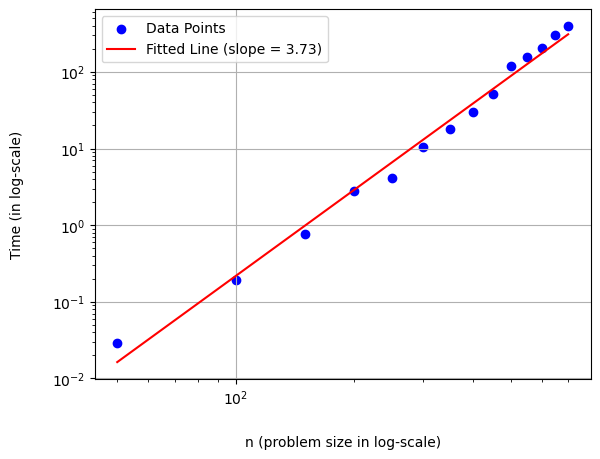

slope of the fitted line:  3.733279850578949


In [220]:
log_n_values = np.log10(n_values)
log_time_values = np.log10(time_values)

slope, intercept, r_value, p_value, std_err = linregress(log_n_values, log_time_values)

fitted_line = 10**(intercept + slope * log_n_values)

plt.scatter(n_values, time_values, color='blue', label='Data Points')

plt.plot(n_values, fitted_line, color='red', label=f'Fitted Line (slope = {slope:.2f})')

plt.xlabel('n (problem size in log-scale)', labelpad=20)
plt.ylabel('Time (in log-scale)', labelpad=20)

plt.xscale('log')
plt.yscale('log')

plt.legend()
plt.grid(True)
plt.show()

print("slope of the fitted line: ", slope)

we imagine the results this algorithm could obtain in practical applications, like for example working in a task of image processing on images 4096x4096:

In [221]:
def model(n, F, b):
    """Function to fit the time complexity curve"""
    
    return F * f_simplex(n) + b

In [222]:
params, covariance = curve_fit(model, n_values, time_values, p0=[1, 0])

fitted_values = model(n_values, *params)

In [223]:
print(f"The best constant F is: {params[0]}")
print(f"The best constant b is: {params[1]}")

The best constant F is: 2.1712773940175345e-08
The best constant b is: -13.348822409178918


In [224]:
n = 4096
F = 2.1712773940175345e-08
b = -13.348822409178918

result = F * n**3 * log(2 * n) * log(2 * n) + b
print("number of hours:", result/(3600))

number of hours: 33.64979529684541


Considering applications in fields like image processing this result is not an acceptable amount of time. 

#### SINKHORN ALGORITHM

In this section we consider a new formulation of the (OT) problem where we consider the task to find the right rescaling vectors to transform a Matrix $K$ representing the Entropy of the system in the final Transport Plan matrix $P$.

$$
P_{i,j} = u_i K_{i,j} v_j
$$

In this new setting we use the Sinkhorn Algorithm to solve it.

In [322]:
def sinkhorn_algorithm(cost_matrix, a, b, reg=0.01, num_iters=500, tol=1e-9):
    """Function to solve the OT problem stated with Rescaling Problem formulation"""
    
    convergence = False

    a_normalized = a / np.sum(a)
    b_normalized = b / np.sum(b)

    K = np.exp(-cost_matrix / reg)
    u = np.ones(len(a))
    v = np.ones(len(b))

    for _ in range(num_iters):
        u = a_normalized / (K @ v)
        v = b_normalized / (K.T @ u)
        
        marginal_error_a = np.linalg.norm(a_normalized - u * (K @ v), 1)
        marginal_error_b = np.linalg.norm(b_normalized - v * (K.T @ u), 1)

        if marginal_error_a + marginal_error_b < tol:
            convergence = True
            break

    P = np.diag(u) @ K @ np.diag(v)
    
    minimal_cost = np.sum(P * cost_matrix)
    
    return P , minimal_cost , convergence

#### TIME COMPLEXITY 

In [323]:
def run_optimal_transport_sink(n):
    """Function to run the Sinkhorn algorithm with a given number of locations"""
    
    C , a , b = generate_random_OT_problem(n, n, n*50, (0,1))

    start_time = time.time()
    P_sinkhorn , obj_sinkhorn , convergence = sinkhorn_algorithm(C, a, b)
    sinkhorn_time = time.time() - start_time

    print("\nSinkhorn Results:")
    print("\nTransport Matrix P (Sinkhorn):\n\n", P_sinkhorn)
    print("\nObjective (Sinkhorn):", obj_sinkhorn)
    print("\nTime (Sinkhorn):", sinkhorn_time)
    print("\nConvergence (Sinkhorn):", convergence)

In [324]:
run_optimal_transport_sink(n=1000)


Sinkhorn Results:

Transport Matrix P (Sinkhorn):

 [[1.68159999e-32 3.40471137e-40 2.59724604e-31 ... 9.29337315e-36
  5.89898167e-22 3.10389618e-17]
 [3.02455167e-21 3.30356068e-11 1.26803561e-27 ... 3.24442396e-44
  5.34305456e-42 6.07856331e-18]
 [3.48835134e-25 2.90785738e-07 7.92037130e-11 ... 2.31075464e-30
  6.67028068e-15 1.22372788e-30]
 ...
 [2.29445814e-19 2.10010239e-07 5.47979824e-29 ... 1.93957907e-11
  2.97309966e-38 8.25972013e-45]
 [3.20321674e-38 1.63059105e-30 1.07586330e-35 ... 2.82554176e-43
  1.87145129e-33 3.81074216e-26]
 [3.53972543e-15 1.78861314e-15 1.45306217e-20 ... 5.23106712e-08
  3.92798875e-44 1.94002960e-12]]

Objective (Sinkhorn): 0.011309332520540075

Time (Sinkhorn): 0.0482330322265625

Convergence (Sinkhorn): True


In [325]:
run_optimal_transport_sink(n=2000)


Sinkhorn Results:

Transport Matrix P (Sinkhorn):

 [[2.67885513e-35 2.32873975e-48 1.05030587e-37 ... 5.42541403e-21
  6.74844173e-46 1.20494986e-27]
 [9.33838486e-33 7.92399076e-17 1.30978999e-39 ... 1.67337667e-09
  1.48462996e-07 2.87509447e-42]
 [1.52536948e-35 1.36074058e-46 2.24742593e-43 ... 3.25073938e-25
  1.75780033e-31 1.38903175e-15]
 ...
 [8.23852700e-47 1.45312701e-20 1.98610138e-20 ... 2.60720004e-18
  4.52538104e-32 8.55367198e-25]
 [3.96368737e-41 2.22390739e-43 2.10704448e-32 ... 1.33421043e-36
  3.18809967e-42 1.40675836e-32]
 [9.79259540e-40 1.04461481e-19 5.23055661e-39 ... 5.38939641e-25
  1.91379605e-37 2.04640079e-39]]

Objective (Sinkhorn): 0.010713973680238081

Time (Sinkhorn): 0.2939951419830322

Convergence (Sinkhorn): True


In [326]:
run_optimal_transport_sink(n=3000)


Sinkhorn Results:

Transport Matrix P (Sinkhorn):

 [[1.24756079e-34 2.62642810e-37 4.94540826e-39 ... 2.86491591e-43
  1.07942147e-29 4.57100536e-10]
 [1.05242428e-42 1.47120461e-28 1.37690512e-24 ... 1.72269641e-16
  5.46763851e-24 3.86792070e-37]
 [1.21830926e-16 1.35602066e-10 1.67753927e-33 ... 1.40907176e-22
  1.35775088e-14 9.02755847e-40]
 ...
 [5.87833871e-21 3.05035959e-08 1.26504847e-24 ... 2.15355620e-32
  6.70421011e-36 3.16027189e-34]
 [2.03870497e-19 1.30588152e-27 5.91072011e-35 ... 8.31384160e-45
  5.99281607e-37 1.99608397e-12]
 [1.06173245e-37 3.20029586e-42 2.53895578e-47 ... 3.44066011e-13
  5.02361270e-11 2.55100668e-23]]

Objective (Sinkhorn): 0.010426528007456025

Time (Sinkhorn): 1.3612000942230225

Convergence (Sinkhorn): True


In [327]:
run_optimal_transport_sink(n=4000)


Sinkhorn Results:

Transport Matrix P (Sinkhorn):

 [[4.52747590e-16 3.00925807e-28 1.26616069e-42 ... 2.23769827e-18
  4.75680221e-48 6.79036278e-13]
 [1.75233887e-34 2.65210303e-39 2.86271562e-08 ... 1.69294301e-37
  3.31353590e-43 5.31526004e-44]
 [1.50229427e-13 1.26425527e-29 6.95407347e-34 ... 4.15761234e-09
  1.06186653e-47 2.88779823e-30]
 ...
 [2.80183717e-36 7.70684920e-27 4.08845456e-42 ... 5.04565717e-17
  5.11858267e-34 8.28945351e-08]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.88454284e-31 5.90077164e-50 6.81176444e-41 ... 3.52010008e-38
  1.80737833e-18 6.87570846e-42]]

Objective (Sinkhorn): 0.010298871297347491

Time (Sinkhorn): 2.361569881439209

Convergence (Sinkhorn): True


In [328]:
run_optimal_transport_sink(n=5000)


Sinkhorn Results:

Transport Matrix P (Sinkhorn):

 [[2.41028621e-46 7.09494668e-38 2.46156114e-07 ... 5.65993107e-15
  4.03199964e-09 1.43911968e-10]
 [1.69980372e-38 1.70924317e-07 7.25856040e-16 ... 4.11715757e-44
  8.31993358e-42 7.12234980e-44]
 [4.15357521e-32 1.51350832e-13 2.15220948e-11 ... 4.74790798e-16
  1.19222009e-47 7.72125737e-17]
 ...
 [1.02447960e-07 2.85691564e-42 3.84041867e-26 ... 1.16602976e-34
  6.62200149e-36 7.83058151e-45]
 [3.84373281e-07 5.53713787e-23 3.29947114e-12 ... 2.04686412e-36
  3.49427729e-39 5.88526599e-10]
 [2.26026231e-42 1.89800990e-47 5.41763548e-15 ... 9.61556247e-23
  2.62413798e-18 2.64739122e-45]]

Objective (Sinkhorn): 0.010210595674054872

Time (Sinkhorn): 4.036981105804443

Convergence (Sinkhorn): True


In [329]:
run_optimal_transport_sink(n=6000)


Sinkhorn Results:

Transport Matrix P (Sinkhorn):

 [[5.41992686e-08 5.40150629e-46 2.86235381e-35 ... 2.48016847e-08
  1.10209928e-18 7.75671134e-34]
 [8.58467108e-41 4.27874320e-14 3.40861934e-08 ... 3.14435689e-14
  2.17631225e-08 4.43665247e-44]
 [1.43052317e-38 3.17779688e-23 5.95881410e-07 ... 8.67075660e-34
  1.76225199e-32 4.44865471e-25]
 ...
 [2.69924361e-25 7.17500816e-11 1.63063684e-19 ... 1.86706453e-35
  7.58013393e-12 9.51556181e-35]
 [7.50646917e-36 1.03626404e-45 2.71037219e-22 ... 1.64532285e-21
  1.17083118e-46 5.84799979e-36]
 [5.17155259e-40 1.80464620e-07 7.63972996e-42 ... 2.27984284e-13
  3.94948766e-45 9.27224264e-31]]

Objective (Sinkhorn): 0.010177244667143428

Time (Sinkhorn): 6.140260934829712

Convergence (Sinkhorn): True


In [330]:
run_optimal_transport_sink(n=7000)


Sinkhorn Results:

Transport Matrix P (Sinkhorn):

 [[4.60877911e-21 5.09457967e-41 1.31154598e-32 ... 2.22524489e-34
  2.61530435e-15 1.05396057e-38]
 [7.68918246e-46 3.05537489e-08 3.03571676e-43 ... 1.47621060e-09
  3.62587981e-29 6.96284662e-25]
 [2.52654520e-48 6.17555088e-30 6.05009931e-21 ... 8.50692061e-31
  1.36289278e-21 5.85981733e-39]
 ...
 [6.37770642e-49 3.81739936e-11 3.61354070e-25 ... 2.38063801e-16
  6.13069322e-35 1.10001520e-41]
 [5.93391506e-19 2.34684715e-07 1.79599018e-48 ... 2.76619113e-25
  2.41022514e-09 2.01438189e-08]
 [7.30897498e-34 1.24484677e-15 9.33635704e-44 ... 2.27335227e-36
  4.00410576e-51 1.43985753e-50]]

Objective (Sinkhorn): 0.01016863343161379

Time (Sinkhorn): 7.92083477973938

Convergence (Sinkhorn): True


In [331]:
run_optimal_transport_sink(n=8000)


Sinkhorn Results:

Transport Matrix P (Sinkhorn):

 [[3.37105459e-49 3.71366077e-34 4.69877754e-11 ... 3.32492252e-16
  2.81845574e-34 3.22880103e-13]
 [1.45077127e-21 1.47306391e-15 4.80293719e-09 ... 3.33794612e-48
  1.76992856e-46 1.21716619e-32]
 [6.22562520e-47 4.91602875e-48 1.50406418e-32 ... 4.45127434e-34
  6.65678845e-24 5.62783916e-36]
 ...
 [4.02371740e-41 1.19415020e-39 3.89151995e-26 ... 7.50721245e-23
  6.71234091e-34 2.51988728e-41]
 [2.18682403e-31 8.96261745e-22 2.42817562e-18 ... 7.21839675e-16
  9.29913760e-19 5.75453473e-50]
 [6.24333417e-41 3.28921076e-34 6.29836989e-47 ... 3.84271907e-24
  1.48548837e-18 1.61334496e-24]]

Objective (Sinkhorn): 0.010117977063189388

Time (Sinkhorn): 13.099141120910645

Convergence (Sinkhorn): True


In [332]:
run_optimal_transport_sink(n=9000)


Sinkhorn Results:

Transport Matrix P (Sinkhorn):

 [[2.02280312e-37 2.08238696e-19 1.55550482e-13 ... 2.33050834e-09
  1.22215730e-32 1.77939639e-25]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.04458435e-26 3.98257068e-36 3.79420650e-18 ... 6.66801588e-22
  9.98534401e-45 5.57662969e-15]
 ...
 [1.33030368e-28 7.93705140e-50 2.46468974e-08 ... 2.10105278e-50
  5.48271153e-21 2.27198977e-09]
 [5.03978081e-34 1.09225412e-38 3.34675652e-49 ... 2.93136469e-42
  1.50974614e-25 9.28971176e-25]
 [3.41149538e-33 8.38581900e-22 1.23314959e-22 ... 2.88711011e-25
  3.44954425e-48 3.33514586e-20]]

Objective (Sinkhorn): 0.010111220201785998

Time (Sinkhorn): 14.972187995910645

Convergence (Sinkhorn): True


In [333]:
run_optimal_transport_sink(n=10000)


Sinkhorn Results:

Transport Matrix P (Sinkhorn):

 [[7.09008108e-13 4.48189773e-31 1.65970867e-17 ... 4.10051975e-21
  3.65599025e-25 1.53876836e-22]
 [1.10979955e-26 1.10912572e-42 1.48517728e-22 ... 3.24859214e-22
  2.27232241e-26 4.53578490e-24]
 [4.99394533e-48 4.77289254e-38 1.19316096e-50 ... 3.45248198e-29
  3.55675539e-31 2.29993892e-28]
 ...
 [3.47591152e-41 5.18792844e-18 9.30425781e-48 ... 1.56936503e-22
  8.75671863e-24 2.23475040e-46]
 [1.05551647e-33 2.09990935e-39 6.12428409e-31 ... 2.13139507e-41
  1.43535857e-09 1.41814693e-42]
 [2.18164676e-42 6.40388282e-43 2.85538447e-21 ... 5.02069208e-45
  1.62731086e-36 3.56568224e-50]]

Objective (Sinkhorn): 0.010104129586202258

Time (Sinkhorn): 21.04201889038086

Convergence (Sinkhorn): True


In [170]:
results_array_tot_sink = [
[1000, 0.0482330322265625],
[2000, 0.2939951419830322],
[3000, 1.3612000942230225],
[4000, 2.361569881439209],
[5000, 4.036981105804443],
[6000, 6.140260934829712],
[7000, 7.92083477973938],
[8000, 13.099141120910645],
[9000, 14.972187995910645],
[10000, 21.04201889038086]]

In [171]:
tuples_array_sink = np.array([(x[0], x[1]) for x in results_array_tot_sink])

n_values_sink = tuples_array_sink[:, 0]  
time_values_sink = tuples_array_sink[:, 1]  

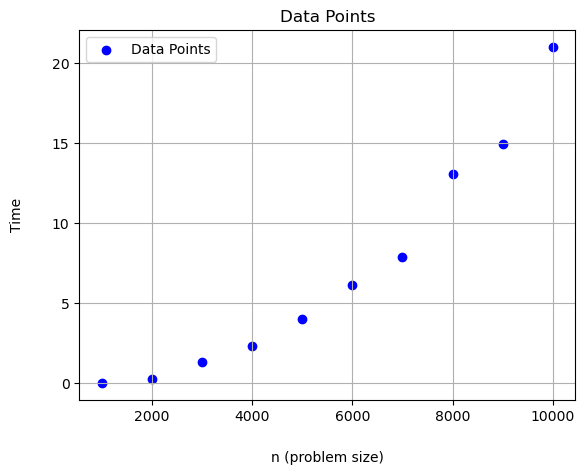

In [172]:
plt.scatter(n_values_sink, time_values_sink, color='blue', label='Data Points')

plt.xlabel('n (problem size)', labelpad=20)
plt.ylabel('Time', labelpad=20)

plt.title('Data Points')

plt.legend()
plt.grid(True)
plt.show()

From the literature the time complexity of the algorithm ( with parameters fixed in order to obtain an error below $\tau$ = 10^-9 ) should be:
$$
O\left( n^2 * log(n) * \tau^{-3} \right)
$$

In [173]:
def f_sinkhorn(n):
    return (n**2 * log(n))

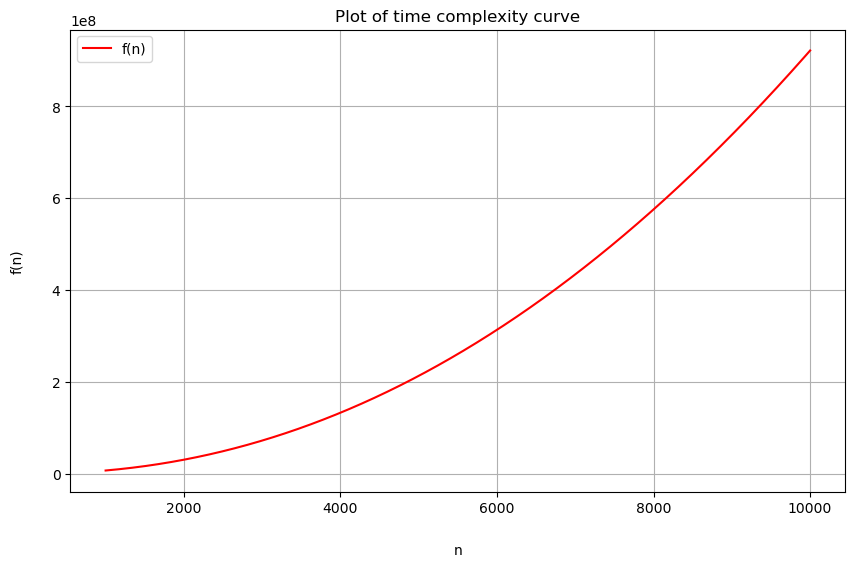

In [174]:
values = np.linspace(1000, 10001, 1000)

f_values = f_sinkhorn(values)

plt.figure(figsize=(10, 6))

plt.plot(values, f_values, label='f(n)', color='red')

plt.xlabel('n', labelpad=20)
plt.ylabel('f(n)', labelpad=20)  

plt.title('Plot of time complexity curve')

plt.legend()
plt.grid(True)
plt.show()

In [175]:
def model(n, F):
    """Function to fit the time complexity curve in log-scale"""
    
    return F * f_sinkhorn(n)

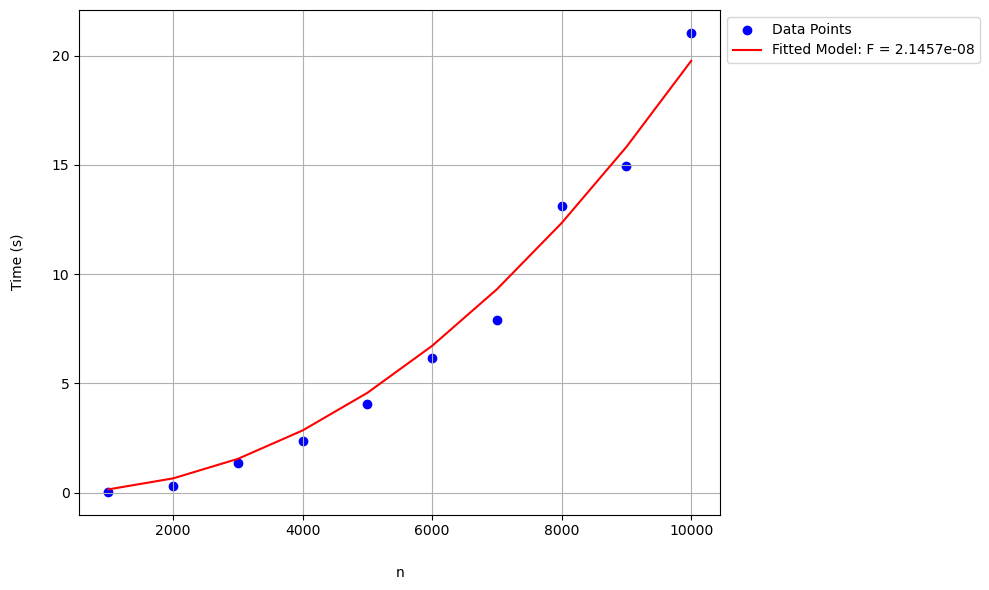

In [177]:
params, covariance = curve_fit(model, n_values_sink, time_values_sink, p0=0.0001)

fitted_values = model(n_values_sink, *params)

plt.figure(figsize=(10, 6))  

plt.scatter(n_values_sink, time_values_sink, color='blue', label='Data Points')
plt.plot(n_values_sink, fitted_values, color='red', label=f'Fitted Model: F = {params[0]:.4e}')

plt.xlabel('n', labelpad=20)
plt.ylabel('Time (s)', labelpad=20)   

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.grid(True)
plt.show()

We move to a log-scale in order to visualize the correlation between the number of locations and the computational complexity

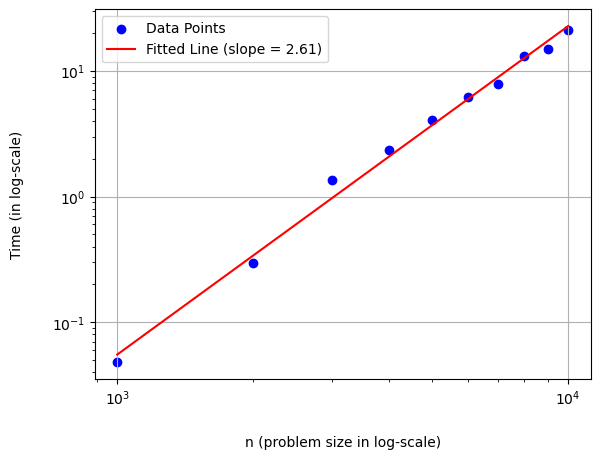

slope of the fitted line:  2.612040390171025


In [166]:
log_n_values_sink = np.log10(n_values_sink)
log_time_values_sink = np.log10(time_values_sink)

slope, intercept, r_value, p_value, std_err = linregress(log_n_values_sink, log_time_values_sink)

fitted_line = 10**(intercept + slope * log_n_values_sink)

plt.scatter(n_values_sink, time_values_sink, color='blue', label='Data Points')

plt.plot(n_values_sink, fitted_line, color='red', label=f'Fitted Line (slope = {slope:.2f})')

plt.xlabel('n (problem size in log-scale)', labelpad=20)
plt.ylabel('Time (in log-scale)', labelpad=20)

plt.xscale('log')
plt.yscale('log')

plt.legend()
plt.grid(True)
plt.show()

print("slope of the fitted line: ", slope)

we imagine the results this algorithm could obtain in practical applications, like for example working in a task of image processing on images 4096x4096:

In [178]:
def model(n, F):
    """Function to fit the time complexity curve"""
    
    return F * f_sinkhorn(n)

In [180]:
params, covariance = curve_fit(model, n_values_sink, time_values_sink, p0=1)

fitted_values = model(n_values_sink, *params)

In [182]:
print(f"The best constant F is: {params[0]}")

The best constant F is: 2.145657428548442e-08


In [184]:
n = 4096
F = 2.2391099248584904e-08

result = F * n**2 * log(n)
print("number of seconds:", result)

number of seconds: 3.124654604810768


#### COMPARISON IN TIME COMPLEXITY

In this section we compare the time compexity curves of the two algorithms in order to show the relevant velocity of the Sinkhorn with respect to the SImplex algorithm.

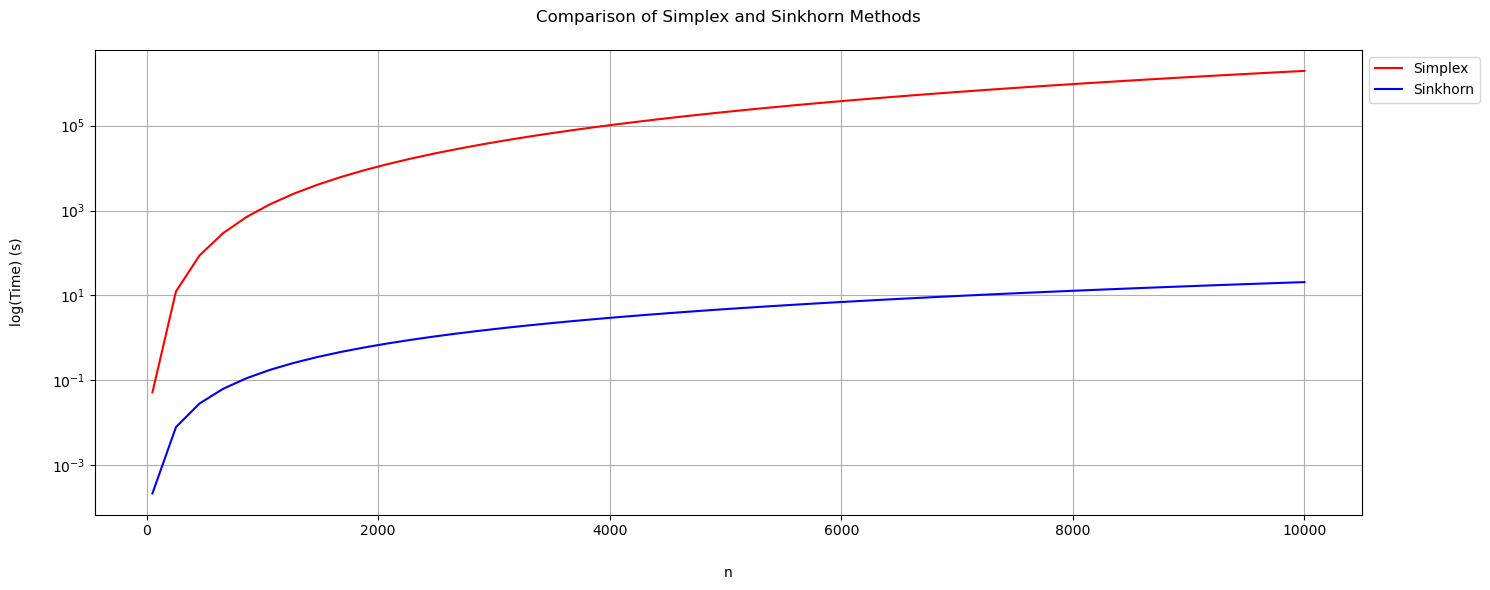

In [167]:
values = np.linspace(50, 10001, 50)

F1 = 1.9724742781851125e-08
F2 = 2.2391099248584904e-08

def f1(n):
    return F1 * f_simplex(n)

def f2(n):
    return F2 * f_sinkhorn(n)

f1_values = f1(values)
f2_values = f2(values)

plt.figure(figsize=(15, 6))
plt.plot(values, f1_values, label='Simplex', color='red')
plt.plot(values, f2_values, label='Sinkhorn', color='blue')

plt.xlabel('n', labelpad=20)
plt.ylabel('log(Time) (s)', labelpad=20)

plt.yscale('log')

plt.title('Comparison of Simplex and Sinkhorn Methods', pad=20)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.grid(True)
plt.show()

#### ANALYSIS IN FUNCTION OF EPSILON $\epsilon$ REGULARIZATION PARAMETER

In this section we analyze how the convergence of the algorithm toward the optimal solution changes in function of the regularization parameter epsilon that defines how much the Sinkhorn algorithm push to solve the original problem, or to maximize entropy.

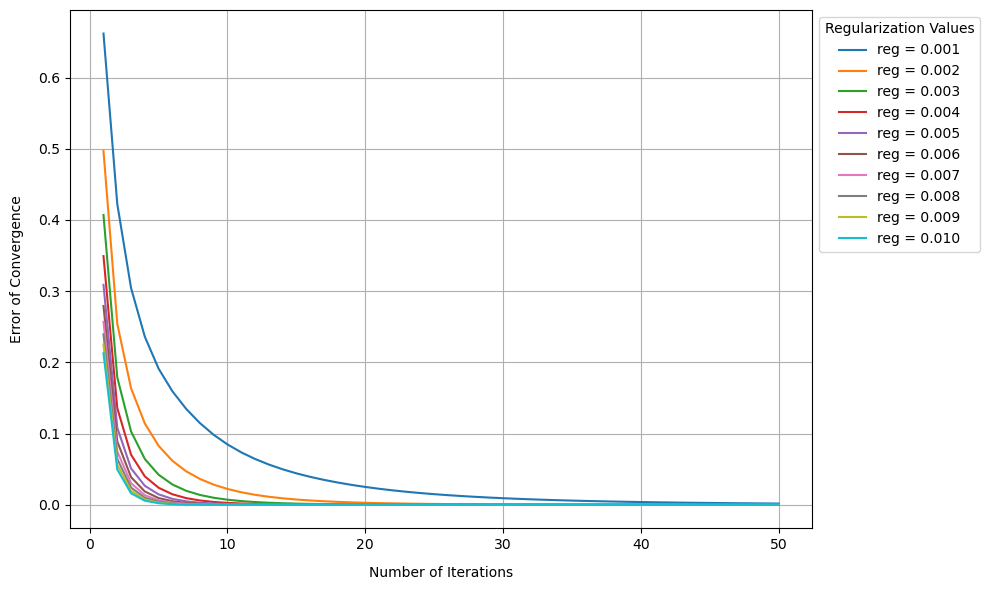

In [196]:
C, a, b = generate_random_OT_problem(1000, 1000, 1000*50, (0, 1))

A = np.zeros((51, 11))  

for j in range(1, 11):  
    for i in range(1, 51):  
        _, obj_sinkhorn, error = sinkhorn_algorithm(C, a, b, reg=0.001*j, num_iters=i)
        A[i, j] = error

# Plotting
plt.figure(figsize=(10, 6))
for j in range(1, 11):
    plt.plot(range(1, 51), A[1:51, j], label=f'reg = {0.001 * j:.3f}')

plt.xlabel('Number of Iterations', labelpad=10)  
plt.ylabel('Error of Convergence', labelpad=10)  
plt.legend(title='Regularization Values', loc='upper left', bbox_to_anchor=(1,1))
plt.grid(True)
plt.tight_layout()
plt.show()


From this plot we can easily notice that as soon as the regularization parameter becomes closer to 0 and therefore the considered problem becomes closer to the original one the Sinkhorn algorithm converges in a larger number of iterations.

altough this fact, for every value of epsilon, 50 iterations seems enough to ensure convergence.

In [282]:
A = []

In [283]:
C , a , b = generate_random_OT_problem(50, 50, 50*50, (0,1))

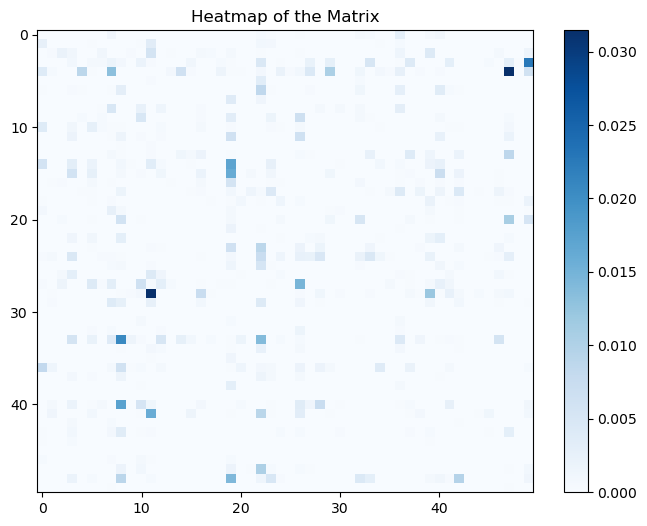

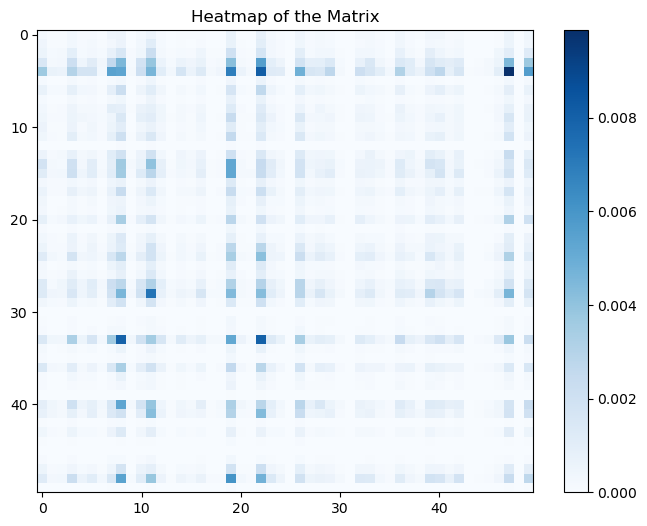

[0.14924257561047358, 0.23660014634493715, 0.3044342250282498, 0.3505505210712302, 0.38222327158751046, 0.4048369646486389, 0.4216249559123463, 0.4345142327073367, 0.44469113236701496, 0.452915221054221]


In [284]:
for i in range(1, 11, 1):
    P_sinkhorn , obj_sinkhorn , convergence = sinkhorn_algorithm(C, a, b, reg=0.1*i, num_iters=50)
    A.append(obj_sinkhorn)

    if i==1 or i==10:
        plot_heatmap(P_sinkhorn)
print(A)

From these plots we can see that the optimal solutions found from the Sinkhorn algorithm differ from those ones found by the Simplex mainly for the considerable reduction in the level of sparsity of the Transport Plan matrix.

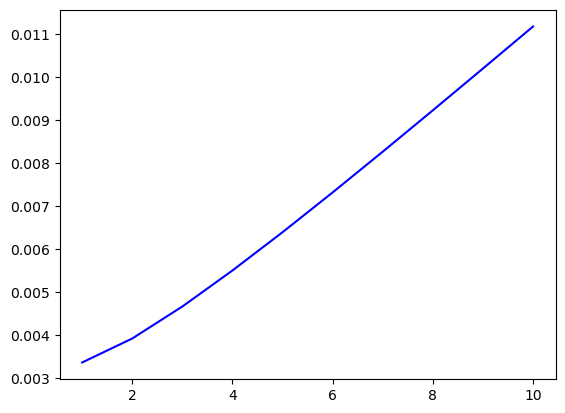

In [235]:
plt.plot(range(1, 11, 1), A, label='Sinkhorn', color='blue') # plot the minimal cost in function of the number of iterations

Finally, from this plot we can analyze that the convergence of the Sinkhorn algorithm toward the optimal minimization cost converges approaching the considered value from below.